# `F = ma` - with activation - extra layer

Let's see what the model does with an extra layer.

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

## Model

Keeping this extremely simple

In [2]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(LinearLayer(2, 64, use_act=use_act), LinearLayer(64, 1, use_act=use_act))

    def forward(self, x):
        return self.layers(x)

## Data

Also keeping this extremely simple

In [3]:
X = torch.rand(10000, 2)  # mass and acceleration respectively
Y = X[:, 0] * X[:, 1]  # force = mass * acceleration
Y = Y[:, None]
X.shape, Y.shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

In [4]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 2]),
 torch.Size([8000, 1]),
 torch.Size([2000, 2]),
 torch.Size([2000, 1]))

## Training

I'll just do full gradient descent to keep things simple.

In [5]:
N = 200  # number of epochs

model = Net(use_act=True)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-3)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/200 [00:00<?, ?it/s]

## Results

In [6]:
def plot_loss(train_loss, valid_loss):
    _, ax = plt.subplots()

    ax.plot(train_loss, label="train")
    ax.plot(valid_loss, label="valid")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()


def get_preds(model):
    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.flatten().numpy()
    y_targs = Y_valid.flatten().numpy()

    return y_preds, y_targs


def get_valid_loss(model):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    return loss_func(out, Y_valid)


def plot_results(y_preds, y_targs):
    _, ax = plt.subplots()

    ax.scatter(y_preds, y_targs, s=4, label="predictions")
    ax.plot(y_targs, y_targs, color="salmon", ls="--", lw=0.5, label="perfect accuracy")
    ax.set(xlabel="y_preds", ylabel="y_targs")
    ax.legend()

Did a bit of HP tuning to get to this thing which looks like it's converged. Looks funky though 🤔

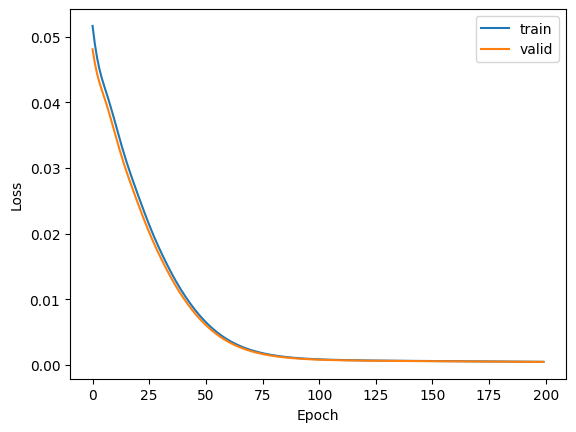

In [7]:
plot_loss(df["train_loss"], df["valid_loss"])

In [8]:
y_preds, y_targs = get_preds(model)

In [9]:
get_valid_loss(model)

tensor(0.0005)

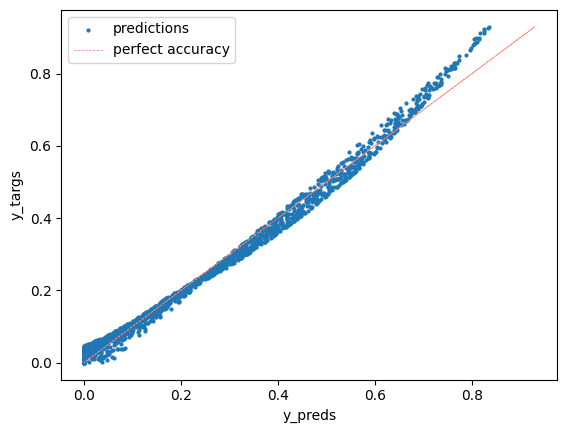

In [10]:
plot_results(y_preds, y_targs)

## Introspection

In [11]:
model

Net(
  (layers): Sequential(
    (0): LinearLayer(
      (linear): Linear(in_features=2, out_features=64, bias=True)
      (act): ReLU()
    )
    (1): LinearLayer(
      (linear): Linear(in_features=64, out_features=1, bias=True)
      (act): ReLU()
    )
  )
)

In [12]:
for name, param in model.named_parameters():
    print(name, "\n", param.data, "\n")

layers.0.linear.weight 
 tensor([[-0.4306,  0.5615],
        [-0.6495, -0.4500],
        [ 0.2636,  0.3128],
        [-0.4882,  0.5869],
        [ 0.0163,  0.6653],
        [-0.4492,  0.5176],
        [ 0.6417,  0.6862],
        [ 0.7070,  0.5859],
        [ 0.4378,  0.4127],
        [-0.5687, -0.6205],
        [-0.2096,  0.0266],
        [-0.4790,  0.2412],
        [ 0.0946, -0.6239],
        [-0.2174,  0.0402],
        [ 0.2232,  0.5121],
        [ 0.2865,  0.3274],
        [-0.0835, -0.2477],
        [-0.1261,  0.5918],
        [ 0.5445, -0.0746],
        [-0.0351, -0.2478],
        [-0.2343,  0.6470],
        [ 0.2523, -0.4812],
        [-0.1161,  0.4007],
        [ 0.4847,  0.1008],
        [ 0.2880, -0.6516],
        [-0.1993, -0.6321],
        [-0.6391,  0.4932],
        [ 0.5436,  0.3149],
        [-0.5420,  0.3686],
        [ 0.1992, -0.2687],
        [-0.4604, -0.6625],
        [-0.2426,  0.1725],
        [-0.6024,  0.6434],
        [-0.2613, -0.2316],
        [ 0.4730, -0.11

In [13]:
# fig, ax = plt.subplots()

# sd = model.state_dict()

# cols = ["salmon", "skyblue"]

# ax.axvline(x=0, color="gray", lw=0.5, label="x=0")
# ax.axhline(y=0, color="gray", lw=0.5, label="y=0")

# ax.scatter(*sd["layers.0.linear.weight"][0], color=cols[0], marker="o")
# ax.scatter(*sd["layers.0.linear.weight"][1], color=cols[0], marker="o")
# ax.scatter(*sd["layers.0.linear.bias"], color=cols[0], marker="x")

# ax.scatter(*sd["layers.1.linear.weight"][0], color=cols[1], marker="o")
# # ax.scatter(*sd["layers.1.linear.bias"], color=cols[1], marker="x")

In [14]:
def get_preds_range(x2=0.5):
    # True solution
    x1 = np.linspace(0, 1, 50)
    x2 = np.repeat(x2, 50)
    y = x1 * x2

    # Predicted solution
    with torch.inference_mode():
        x = torch.stack([torch.as_tensor(x1), torch.as_tensor(x2)]).T.float()
        y_hat = model(x)
        y_hat = y_hat.detach().numpy()

    return y_hat, y


def get_preds_multi_range():
    x2s = np.linspace(0, 1, 11)
    rows = []
    for x2 in x2s:
        row = {"x2": x2}
        row["y_hat"], row["y"] = get_preds_range(x2=x2)
        rows.append(row)
    return rows

In [15]:
results = get_preds_multi_range()

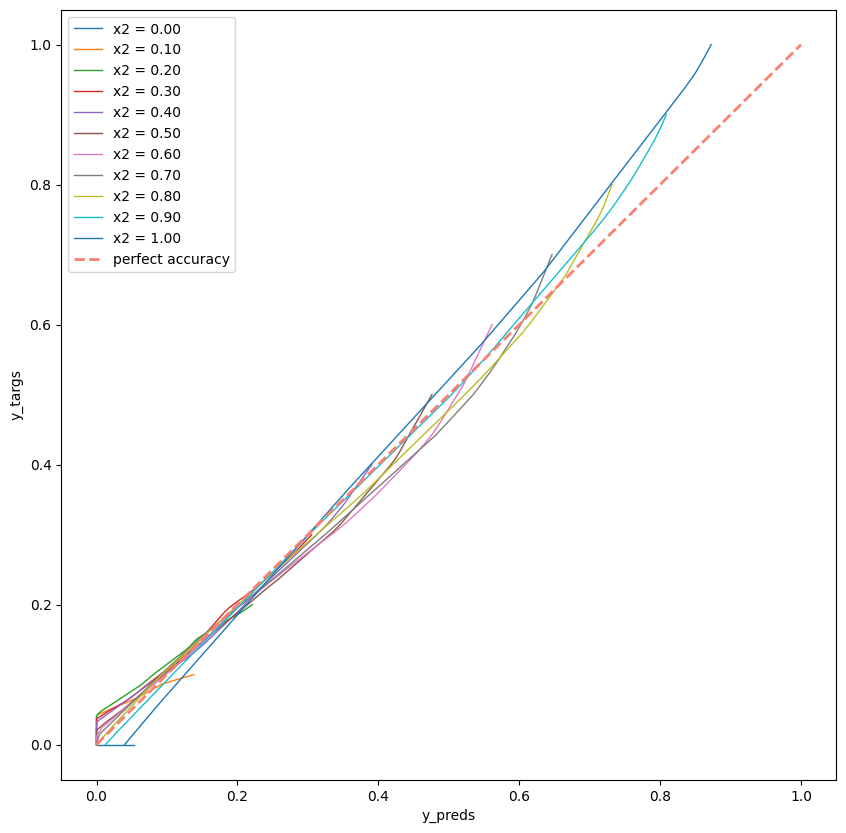

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))

for row in results:
    ax.plot(row["y_hat"], row["y"], lw=1, label=f"x2 = {row['x2']:.2f}")

ax.plot([0, 1], [0, 1], color="salmon", lw=2, ls="--", label="perfect accuracy")
ax.set(xlabel="y_preds", ylabel="y_targs")
ax.legend()

(array([1934., 1284.,  927.,  761.,  658.,  506.,  424.,  396.,  339.,
         276.,  183.,  144.,   79.,   61.,   28.]),
 array([7.14122652e-05, 6.53936788e-02, 1.30715936e-01, 1.96038201e-01,
        2.61360466e-01, 3.26682717e-01, 3.92004997e-01, 4.57327247e-01,
        5.22649527e-01, 5.87971807e-01, 6.53294027e-01, 7.18616307e-01,
        7.83938587e-01, 8.49260867e-01, 9.14583087e-01, 9.79905367e-01]),
 <BarContainer object of 15 artists>)

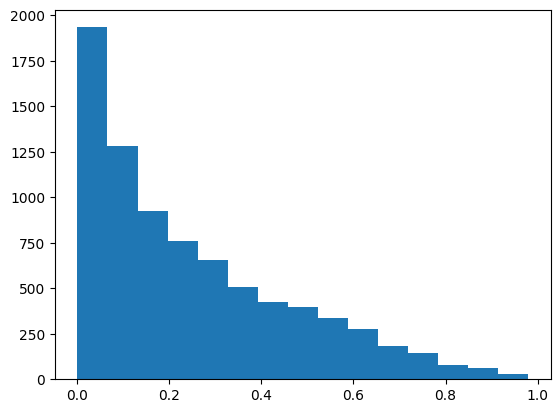

In [17]:
plt.hist(Y_train.flatten(), bins=15)